# Computing Plankton Index

In [1]:
import numpy as np
import scipy as sp
from scipy.spatial import ConvexHull, convex_hull_plot_2d
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
from mpl_toolkits import mplot3d


### Importing MVCO data

In [2]:
df = pd.read_csv('/D/MIT-WHOI/data/2021/biovol_concentration_by_class_time_seriesCNN_hourly19Aug2021.csv')
df_daily =  pd.read_csv('/D/MIT-WHOI/data/2021/biovol_concentration_by_class_time_series_CNN_daily19Aug2021.csv')
df["id"] = df.index
df_daily["id"] = df_daily.index

print(df.head())
df_filtered =pd.melt(df,id_vars = ['datetime'], var_name = 'species',value_name='biovol/mL')
df_daily_filtered =pd.melt(df_daily,id_vars = ['datetime'], var_name = 'species',value_name='biovol/mL')

               datetime  Acanthoica_quattrospina  Akashiwo  \
0  06-Jun-2006 18:56:16                 0.000000       0.0   
1  06-Jun-2006 19:18:01                 0.000000       0.0   
2  06-Jun-2006 20:23:16                 0.000000       0.0   
3  06-Jun-2006 21:17:32                 0.000000       0.0   
4  06-Jun-2006 22:25:43                34.815354       0.0   

   Alexandrium_catenella  Amphidinium  Amylax  Apedinella  \
0                    0.0          0.0     0.0    0.000000   
1                    0.0          0.0     0.0    0.000000   
2                    0.0          0.0     0.0    0.000000   
3                    0.0          0.0     0.0    0.000000   
4                    0.0          0.0     0.0   96.448108   

   Asterionellopsis_glacialis  Bacillaria  Bacillariophyceae  ...     pennate  \
0                  190.513016         0.0         311.643280  ...    0.000000   
1                    0.000000         0.0          56.404548  ...  361.366141   
2                

### Importing ClassList to group species into functional groupsfrom datetime import datetime

In [3]:
clist = pd.read_csv('/D/MIT-WHOI/data/2021/IFCB_classlist_type.csv') #importing 

clist = pd.melt(clist,id_vars = ['CNN_classlist'], var_name = 'group',value_name='in_out')

clist_filtered = clist[clist['in_out']==1]

clist_filtered = clist_filtered.rename(columns = {"CNN_classlist":'species','in_out':'present'})

print(clist_filtered.head())

merged = df_filtered.join(clist_filtered.set_index('species'),on = 'species')

print(merged.head())

merged_daily = df_daily_filtered.join(clist_filtered.set_index('species'),on = 'species')

print(merged.head())

                                        species   group  present
0                       Chaetoceros_tenuissimus  Diatom      1.0
1                             Cylindrotheca_min  Diatom      1.0
2                          Eucampia_morphytype1  Diatom      1.0
3  Guinardia_delicatula_TAG_Amphidinium_grazing  Diatom      1.0
4                        Hemiaulus_membranaceus  Diatom      1.0
               datetime                  species  biovol/mL            group  \
0  06-Jun-2006 18:56:16  Acanthoica_quattrospina        0.0  Coccolithophore   
0  06-Jun-2006 18:56:16  Acanthoica_quattrospina        0.0             Nano   
1  06-Jun-2006 19:18:01  Acanthoica_quattrospina        0.0  Coccolithophore   
1  06-Jun-2006 19:18:01  Acanthoica_quattrospina        0.0             Nano   
2  06-Jun-2006 20:23:16  Acanthoica_quattrospina        0.0  Coccolithophore   

   present  
0      1.0  
0      1.0  
1      1.0  
1      1.0  
2      1.0  
               datetime                  species  b

### converting from long to short format for data set

 resetting index (req'd to make sure valuable data don't become row indexes (row names))

In [4]:
df_long = merged[['datetime','group','biovol/mL']]

df_daily_long = merged_daily[['datetime','group','biovol/mL']]

df_daily_long.to_csv('/D/MIT-WHOI/data/2021/df_daily_long.txt',sep= " ",index = False)

df_short = df_long.pivot_table(index=["datetime"], 
                    columns='group', 
                    values='biovol/mL')

df_short.head()

df_short.index.name = 'datetime'
df_short.reset_index(inplace=True)

df_short['datetime'].head()

df_short['datetime'] =  pd.to_datetime(df_short['datetime'], format="%d-%b-%Y %X")

### creating year decimal column for df_short

need to have datetime object that is =  year + (day of year/365) for the plankton index.

In [12]:
year = pd.to_numeric(df_short["datetime"].dt.year)
doy = pd.to_numeric(df_short["datetime"].dt.dayofyear).div(365)

df_short["yearday"] = year + doy

df_short["year"] = year

df_short["month"] = pd.to_numeric(df_short["datetime"].dt.month)

df_short['datetime'] = df_short['datetime'].dt.date

print(df_short.head())

group    datetime      Ciliate  Coccolithophore        Diatom  Dinoflagellate  \
0      2007-04-01  1952.162094       128.998273  30550.985713     2599.249141   
1      2007-04-01  1888.968813        89.118841  27507.200308     3102.500260   
2      2007-04-01  2734.251767       219.056383  25738.830229     2365.043237   
3      2007-04-01  1506.973968        73.365809  31687.382353     2894.457052   
4      2007-04-01  2232.721254        82.716600  29088.064968     2810.684279   

group  IFCB artifact         Nano    Other live  Other not alive   flagellate  \
0         670.644834  7367.429339    453.713189      5210.114861  9417.239577   
1         565.436912  8360.338310  25927.564471      3278.830726  7379.291988   
2         897.389025  8509.690338    832.300632      5582.237795  7634.988547   
3        2653.760872  8237.828202   8212.188449      2961.487625  6827.584882   
4         485.804170  8505.711531    267.929262      2237.366669  7458.138996   

group  pennatediatom      

### subsetting df_short to create smaller csv to export for plankton index submission

In [13]:
# df_dd.to_csv('/D/MIT-WHOI/github_repos/plankton-index/df_dd.txt',sep= " ",index = False)

# df_dd = df_short[["yearday","Diatom","Dinoflagellate","Nano","Ciliate","Coccolithophore"]]

# df_dd.to_csv('/D/MIT-WHOI/github_repos/plankton-index/df_dd.txt',sep= " ",index = False)

NameError: name 'df_dd' is not defined

### incorporating temperature data

In [14]:
dftemp = pd.read_csv("/D/MIT-WHOI/data/2021/temp_total.csv",header = None)
dftemp_time = pd.read_csv("/D/MIT-WHOI/data/2021/temp_total_time_num.csv", header = None)


dftemp = pd.concat([dftemp[col] for col in dftemp]) # data comes in as 366 x 12 column. flattening to get 1 data column 
dftemp_time = pd.concat([dftemp_time[col] for col in dftemp_time]) #also flattening for time column 
dftemp_time_conv = pd.to_datetime(dftemp_time, format='%Y%m%d', errors='ignore')
# dftemp.head()
# dftemp_time_conv.head()

dft = pd.concat([dftemp_time_conv,dftemp],axis =1) #combining into one dataframe with just datetime and temperature
dft = dft.rename(columns={0: "datetime", 1: "temp"}) #

In [16]:
print(dft.head())
print(df_short.head())
dft["datetime"].dtypes
df_short["datetime"].dtypes

dft['datetime'] = pd.to_datetime(dft['datetime'], format = '%Y-%m-%d')
df_short['datetime'] = pd.to_datetime(df_short["datetime"], format = '%Y-%m-%d')

    datetime    temp
0 2003-01-01  4.2100
1 2003-01-02  0.0000
2 2003-01-03  3.6808
3 2003-01-04  3.7418
4 2003-01-05  3.8182
group   datetime      Ciliate  Coccolithophore        Diatom  Dinoflagellate  \
0     2007-04-01  1952.162094       128.998273  30550.985713     2599.249141   
1     2007-04-01  1888.968813        89.118841  27507.200308     3102.500260   
2     2007-04-01  2734.251767       219.056383  25738.830229     2365.043237   
3     2007-04-01  1506.973968        73.365809  31687.382353     2894.457052   
4     2007-04-01  2232.721254        82.716600  29088.064968     2810.684279   

group  IFCB artifact         Nano    Other live  Other not alive   flagellate  \
0         670.644834  7367.429339    453.713189      5210.114861  9417.239577   
1         565.436912  8360.338310  25927.564471      3278.830726  7379.291988   
2         897.389025  8509.690338    832.300632      5582.237795  7634.988547   
3        2653.760872  8237.828202   8212.188449      2961.487625  682

### committing to merge

In [17]:
df_joined = pd.merge(df_short,dft, how = "outer", on = "datetime")

df_joined.head()


datetime      Ciliate  Coccolithophore        Diatom  Dinoflagellate  \
0 2007-04-01  1952.162094       128.998273  30550.985713     2599.249141   
1 2007-04-01  1888.968813        89.118841  27507.200308     3102.500260   
2 2007-04-01  2734.251767       219.056383  25738.830229     2365.043237   
3 2007-04-01  1506.973968        73.365809  31687.382353     2894.457052   
4 2007-04-01  2232.721254        82.716600  29088.064968     2810.684279   

   IFCB artifact         Nano    Other live  Other not alive   flagellate  \
0     670.644834  7367.429339    453.713189      5210.114861  9417.239577   
1     565.436912  8360.338310  25927.564471      3278.830726  7379.291988   
2     897.389025  8509.690338    832.300632      5582.237795  7634.988547   
3    2653.760872  8237.828202   8212.188449      2961.487625  6827.584882   
4     485.804170  8505.711531    267.929262      2237.366669  7458.138996   

   pennatediatom      yearday    year  month    temp  
0    8072.702143  2007.249315  2007.0    4.0  4.6699  
1    2311.426774  2007.249315  2007.0    4.0  4.6699  
2    1222.872836  2007.249315  2007.0    4.0  4.6699  
3    1858.771796  2007.249315  2007.0    4.0  4.6699  
4    2141.084450  2007.249315  2007.0    4.0  4.6699

Text(0.5, 1.0, 'Diatom/Dinoflagellate Ratio by Year')

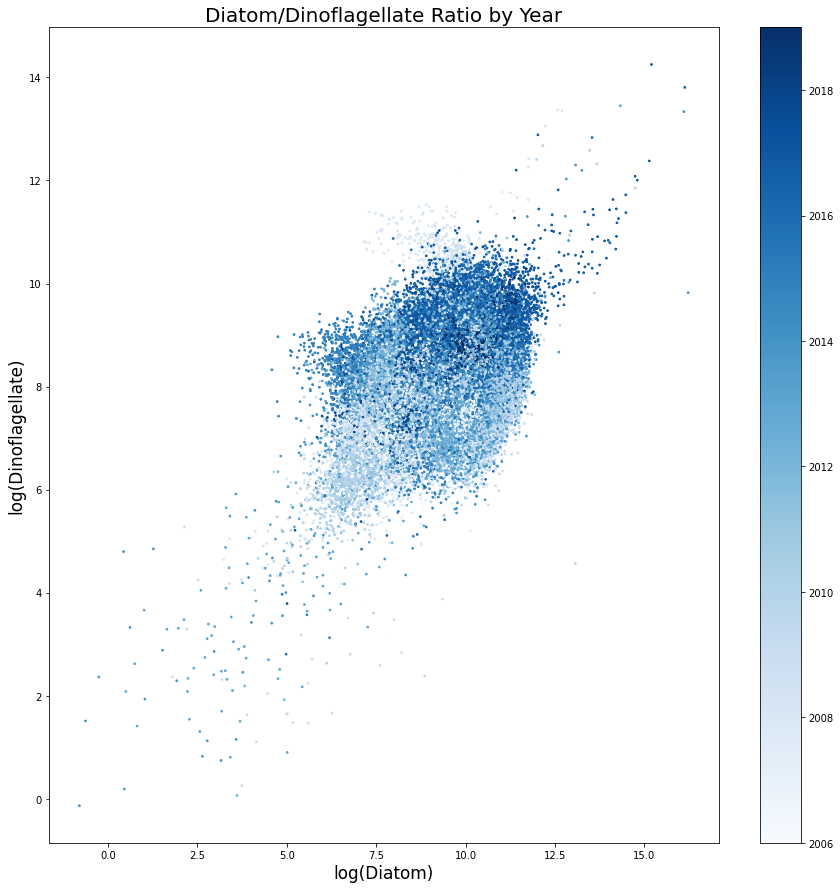

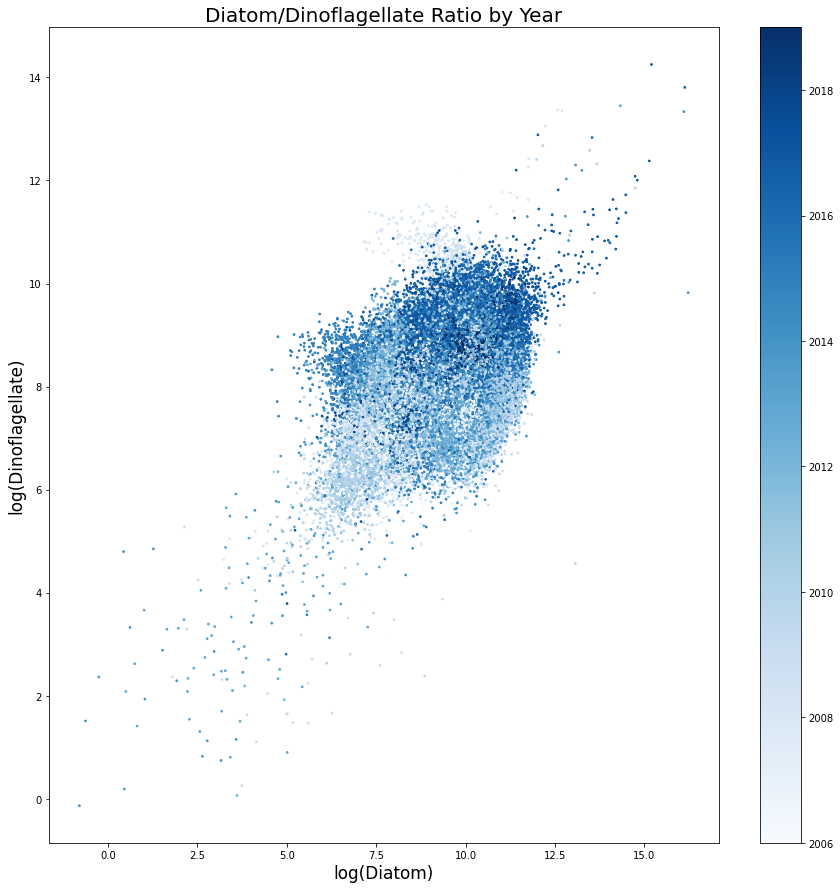

In [18]:
x = "Diatom"
y = "Dinoflagellate"
fig,ax = plt.subplots(figsize = (15,15))
# fig(figsize=(10, 10), dpi=80)

#S1,S2, YEAR
plt.scatter(np.log(df_short[x]),
        np.log(df_short[y]),
        c=df_short["year"],
       cmap = "Blues",
       s = 3)

plt.colorbar()
plt.xlabel("log("+x+")",size = 17)
plt.ylabel("log("+y+")",size = 17)
plt.title(x+"/"+y+ " Ratio by Year",size = 20)

fig,ax = plt.subplots(figsize = (15,15))
# fig(figsize=(10, 10), dpi=80)

#S1,S2, YEAR
plt.scatter(np.log(df_short[x]),
        np.log(df_short[y]),
        c=df_short["year"],
       cmap = "Blues",
       s = 3)

plt.colorbar()
plt.xlabel("log("+x+")",size = 17)
plt.ylabel("log("+y+")",size = 17)
plt.title(x+"/"+y+ " Ratio by Year",size = 20)


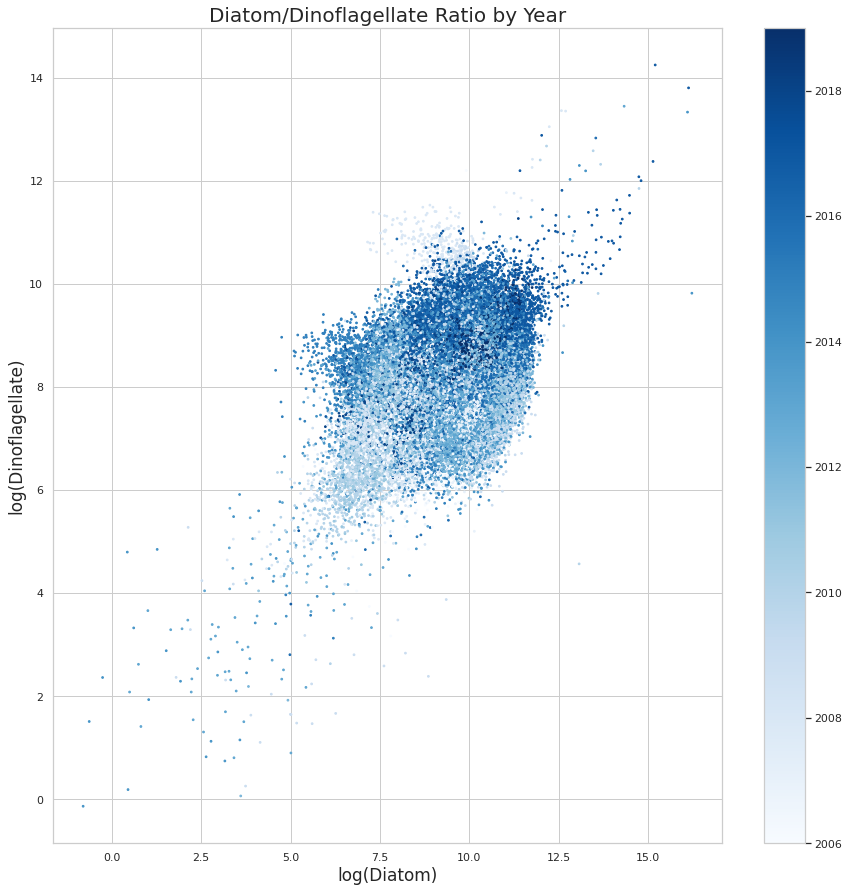

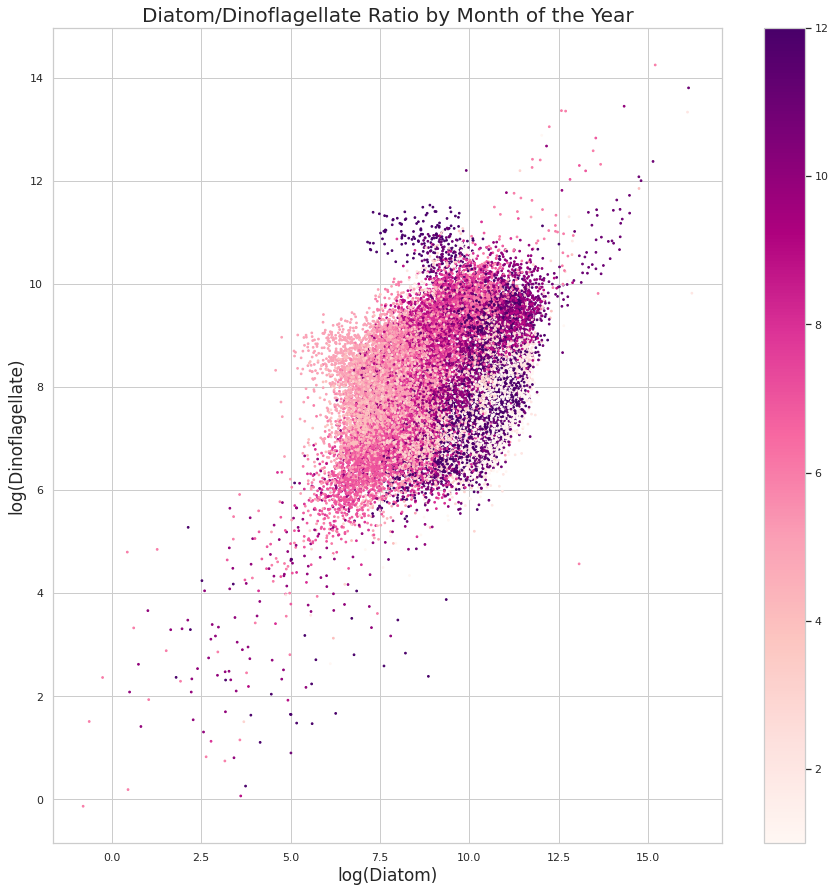

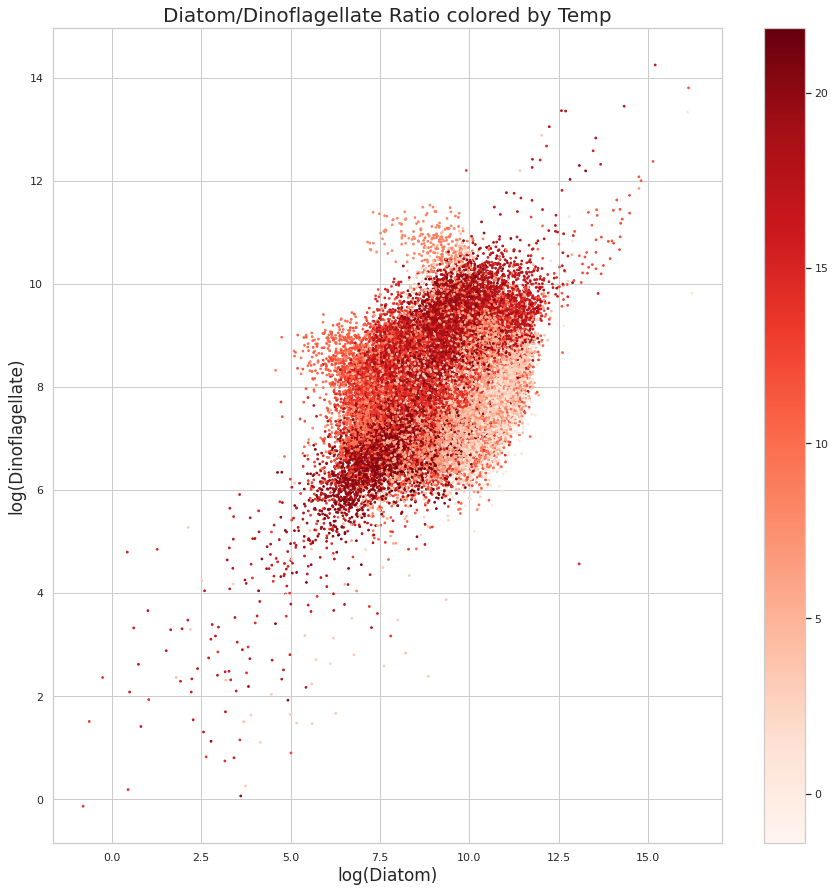

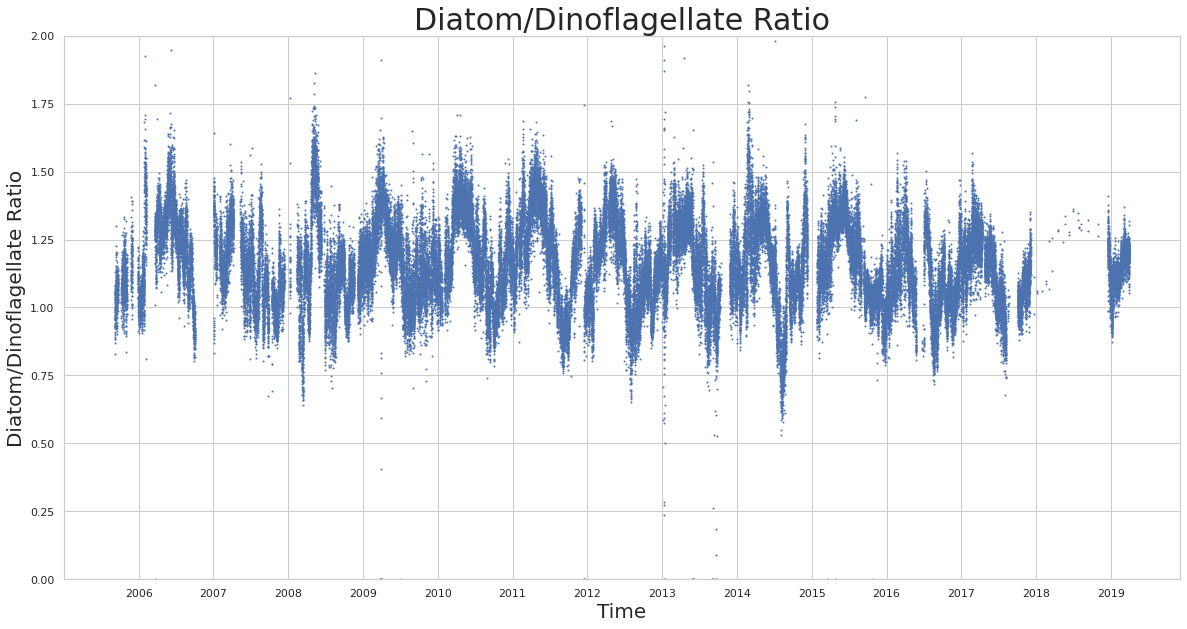

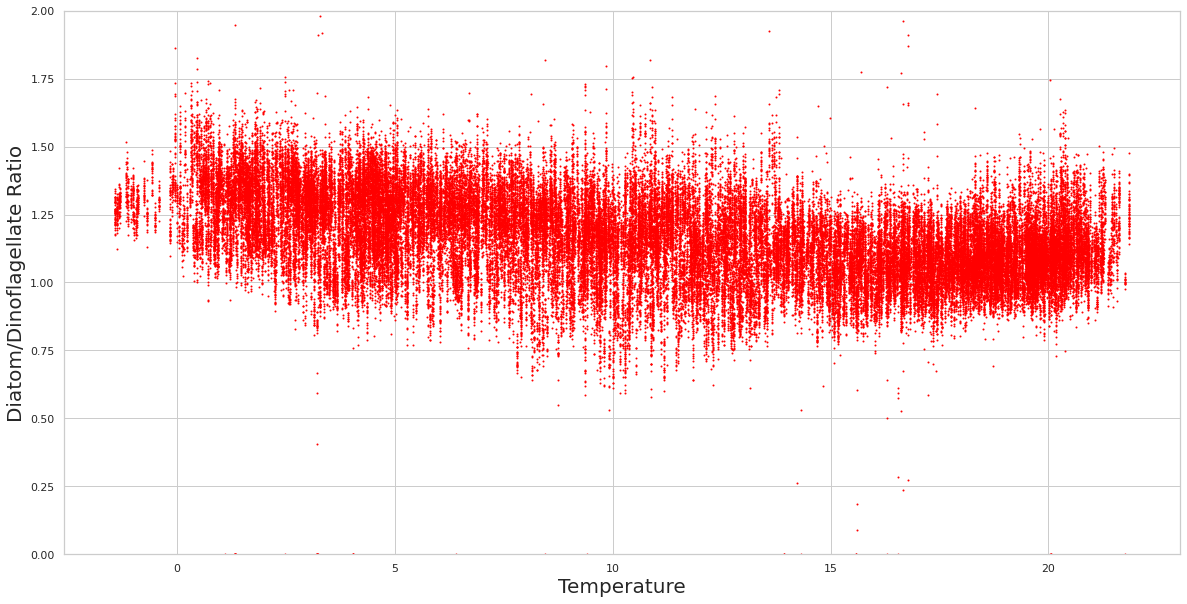

In [19]:
def plotratios(x,y):
    
    sns.set_theme("notebook")#setting theme
    sns.set_style("whitegrid") #setting white grid marks
    
    plt.rcParams.update({'font.size':22})  
    
    fig,ax = plt.subplots(figsize = (15,15))
    #     figure(figsize=(10, 10), dpi=80)

    #S1,S2, YEAR
    plt.scatter(np.log(df_short[x]),
                np.log(df_short[y]),
                c=df_short["year"],
               cmap = "Blues",
               s = 3)

    plt.colorbar()
    plt.xlabel("log("+x+")",size = 17)
    plt.ylabel("log("+y+")",size = 17)
    plt.title(x+"/"+y+ " Ratio by Year",size = 20)
    
    fig,ax = plt.subplots(figsize = (15,15))

#     figure(figsize=(10, 10), dpi=80) 

    #S1,S2, MONTH
    plt.scatter(np.log(df_short[x]),
                np.log(df_short[y]),
                c=df_short["month"],
               cmap = "RdPu",
               s = 3)

    plt.colorbar()
    plt.xlabel("log("+x+")",size = 17)
    plt.ylabel("log("+y+")",size = 17)
    plt.title(x+"/"+y+ " Ratio by Month of the Year",size = 20)
    
    fig,ax = plt.subplots(figsize = (15,15))

#     figure(figsize=(10, 10), dpi=80) 

    #S1,S2,TEMP
    plt.scatter(np.log(df_joined[x]),
                np.log(df_joined[y]),
                c=df_joined["temp"],
               cmap = "Reds",
               s = 3)
    plt.colorbar()
    plt.xlabel("log("+x+")",size = 17)
    plt.ylabel("log("+y+")",size = 17)
    plt.title(x+"/"+y+ " Ratio colored by Temp",size = 20)
    
    #TIME VS RATIO
    df_short["Ratio"]=np.log(df_short[x])/np.log(df_short[y])

    fig, ax = plt.subplots(figsize=(20,10))

    ax.scatter(df_short["datetime"],

               df_short["Ratio"]
               ,s= 1)

    fmt_full_year = mdates.MonthLocator(interval=12)
    ax.xaxis.set_major_locator(fmt_full_year)
    # ax.plot(df_short["datetime"],df_short["SMA_100"],color = "red")

    plt.xlabel("Time",size = 20)
    plt.ylabel(x+"/"+y+" Ratio",size = 20)
    plt.ylim((0,2))
    plt.title(x+"/"+y+" Ratio",size = 30)

    date_form = DateFormatter("%Y")
    ax.xaxis.set_major_formatter(date_form)
    
    #TEMP VS RATIO
    
    fig, ax = plt.subplots(figsize=(20,10))

    df_joined["Ratio"]=np.log(df_joined[x])/np.log(df_joined[y])

    ax.scatter(df_joined["temp"],
              df_joined["Ratio"]
               ,s= 1,c = "Red")
    plt.ylim(0,2)
    plt.xlabel("Temperature",size = 20)
    plt.ylabel(x+"/"+y+" Ratio",size = 20)

plotratios('Diatom',"Dinoflagellate")    


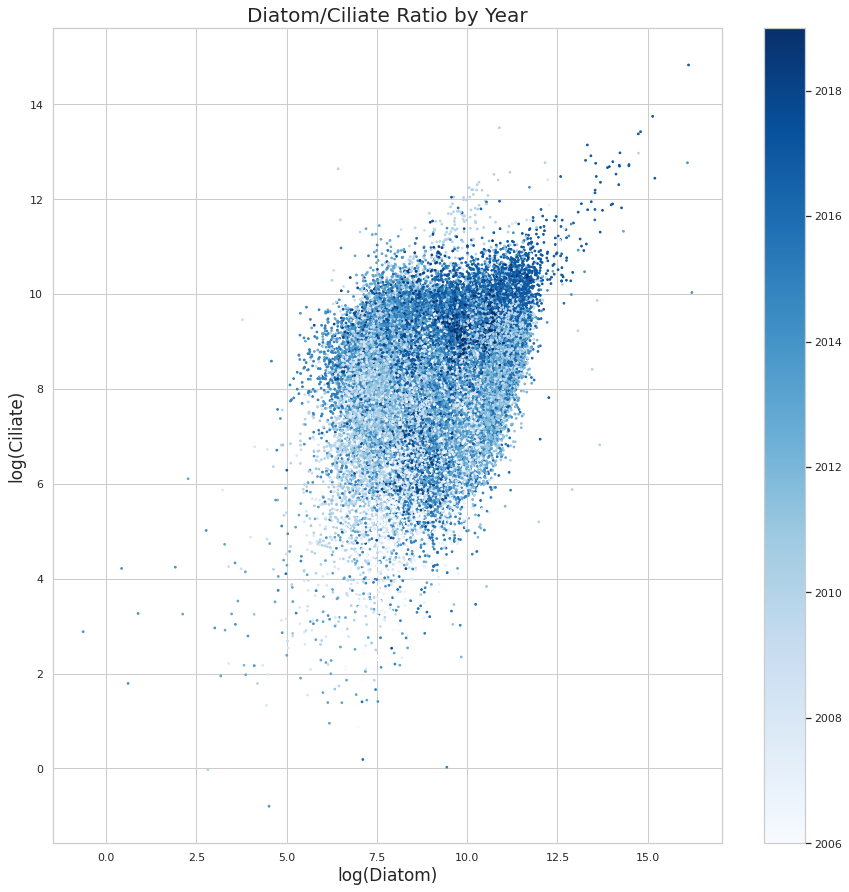

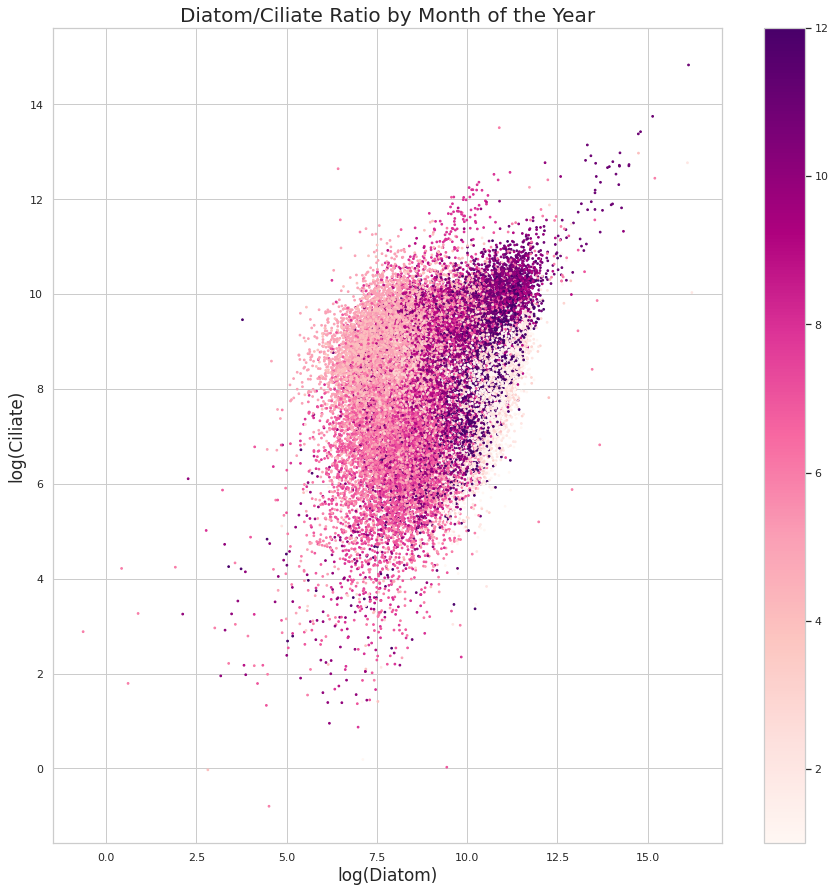

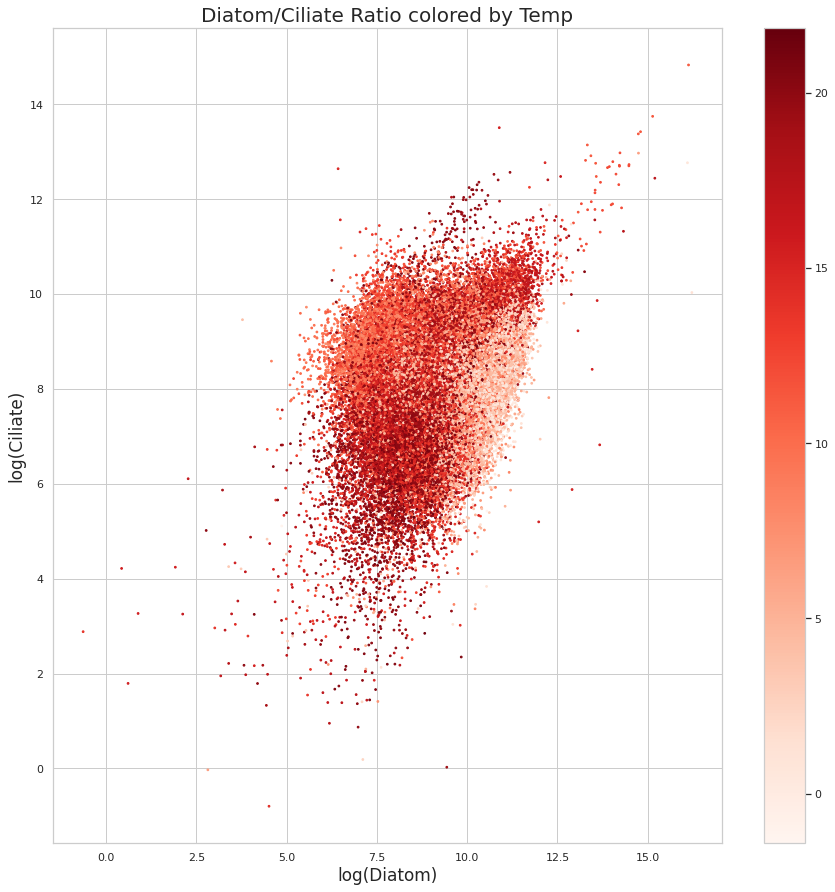

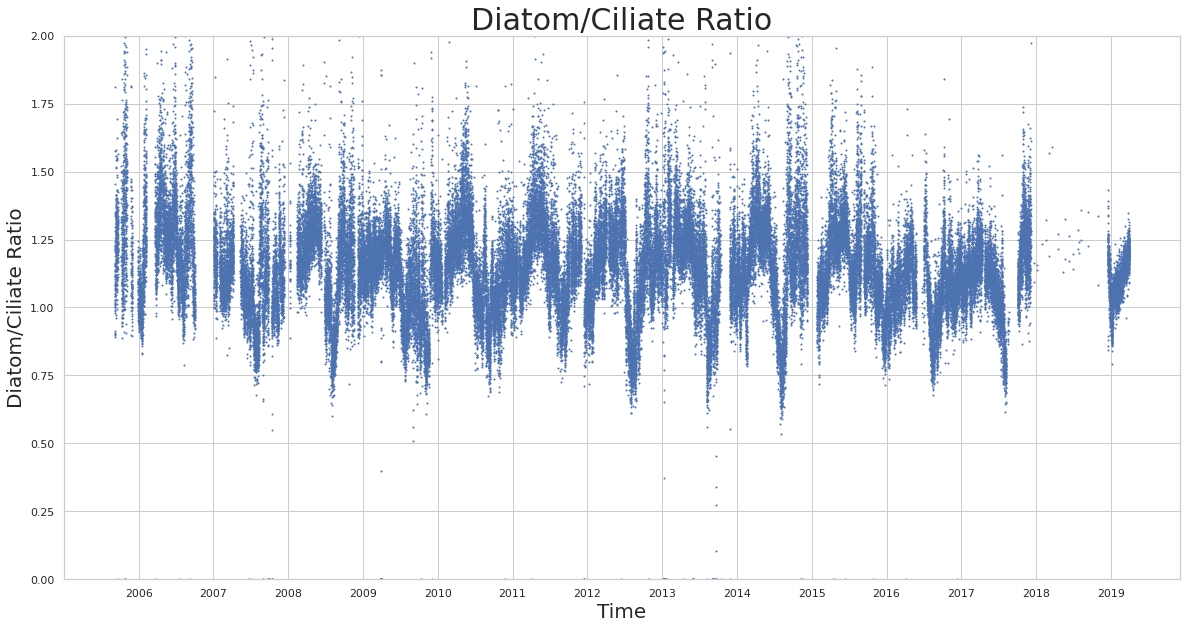

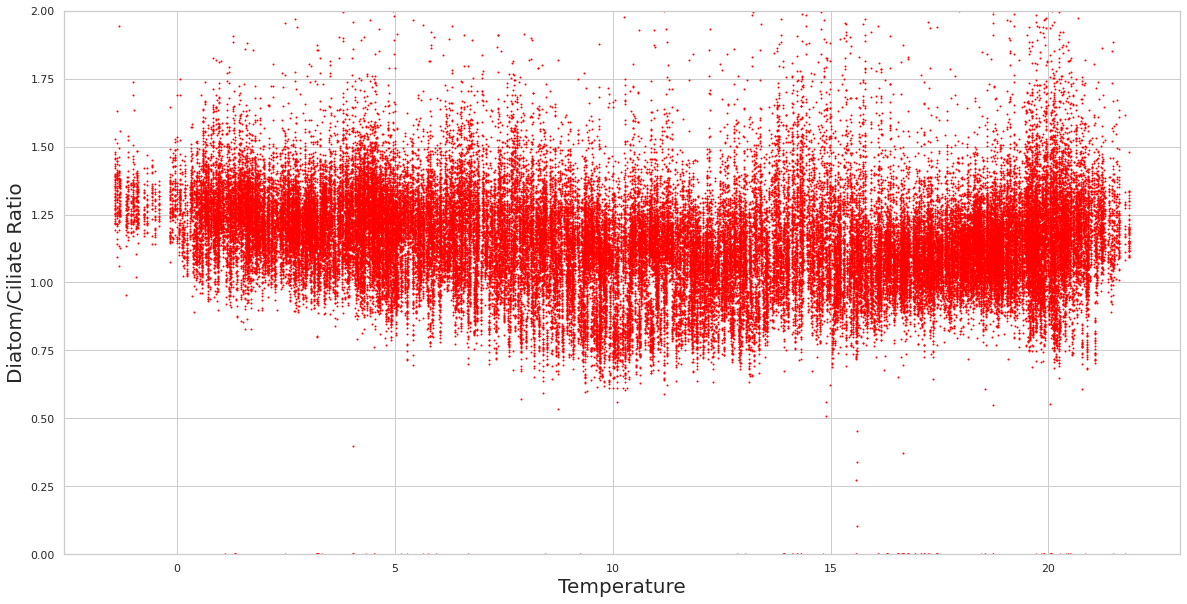

In [20]:
plotratios("Diatom","Ciliate")

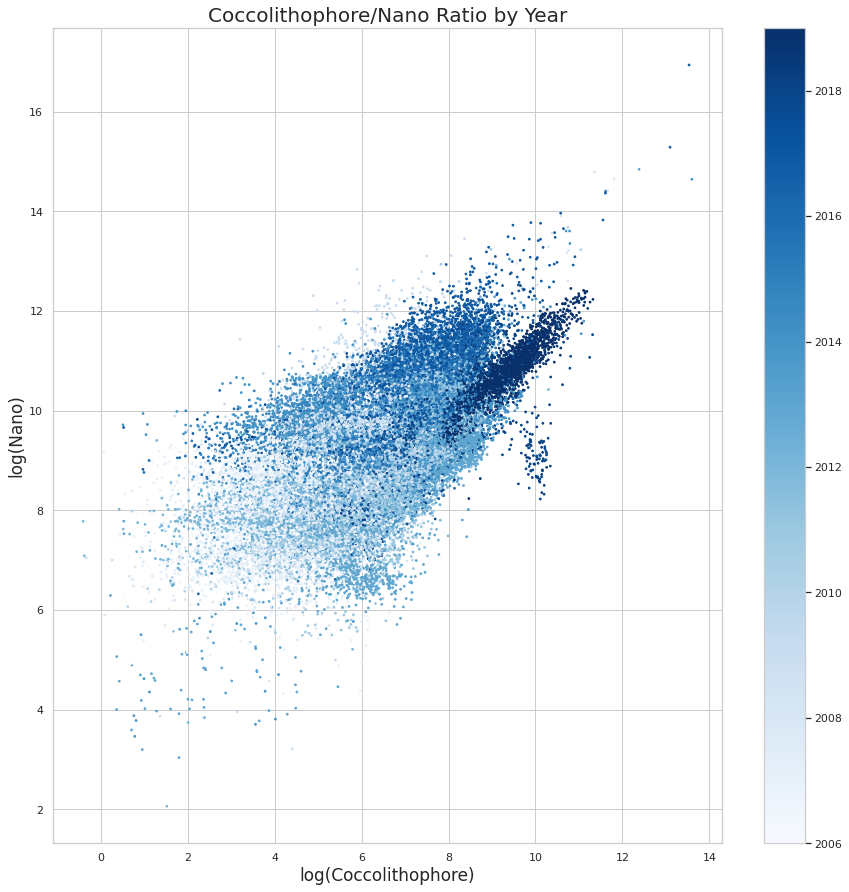

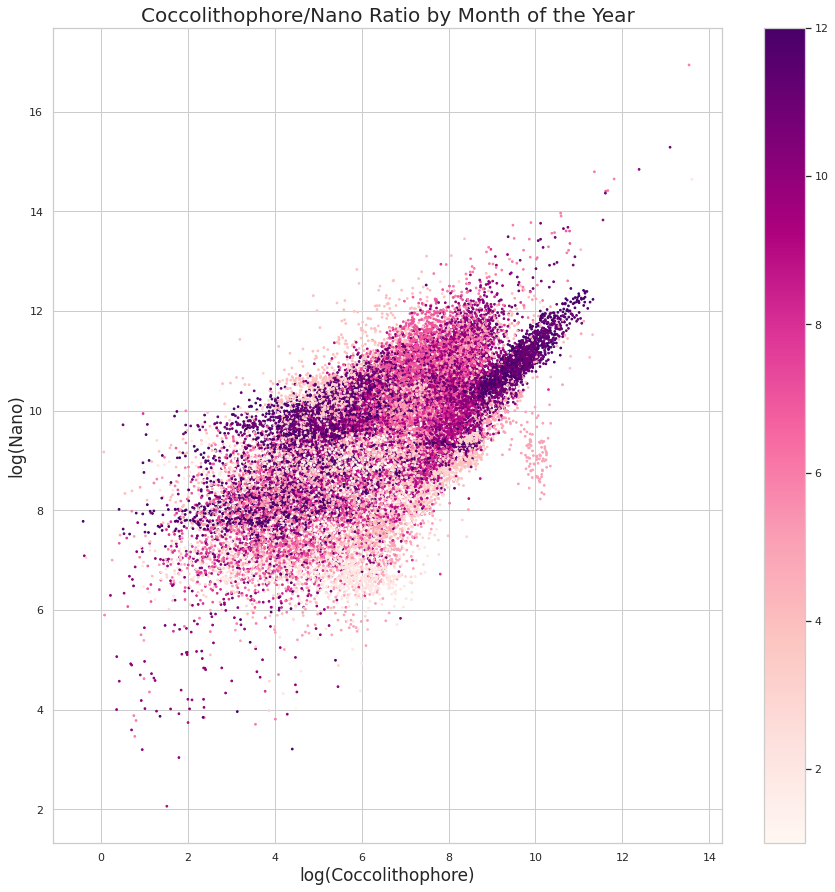

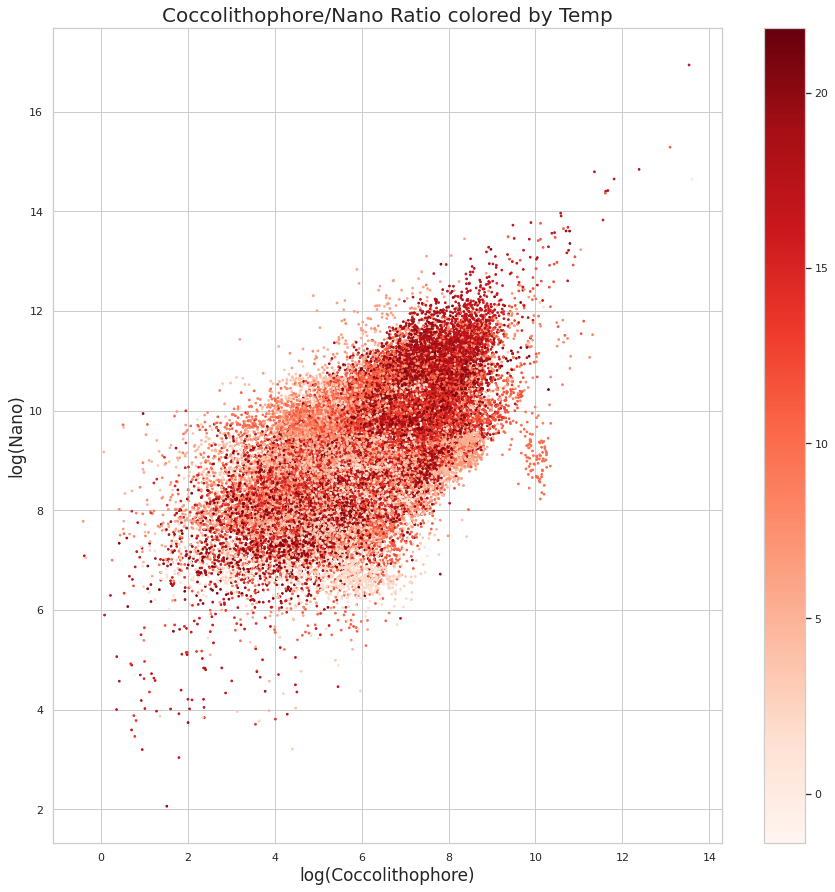

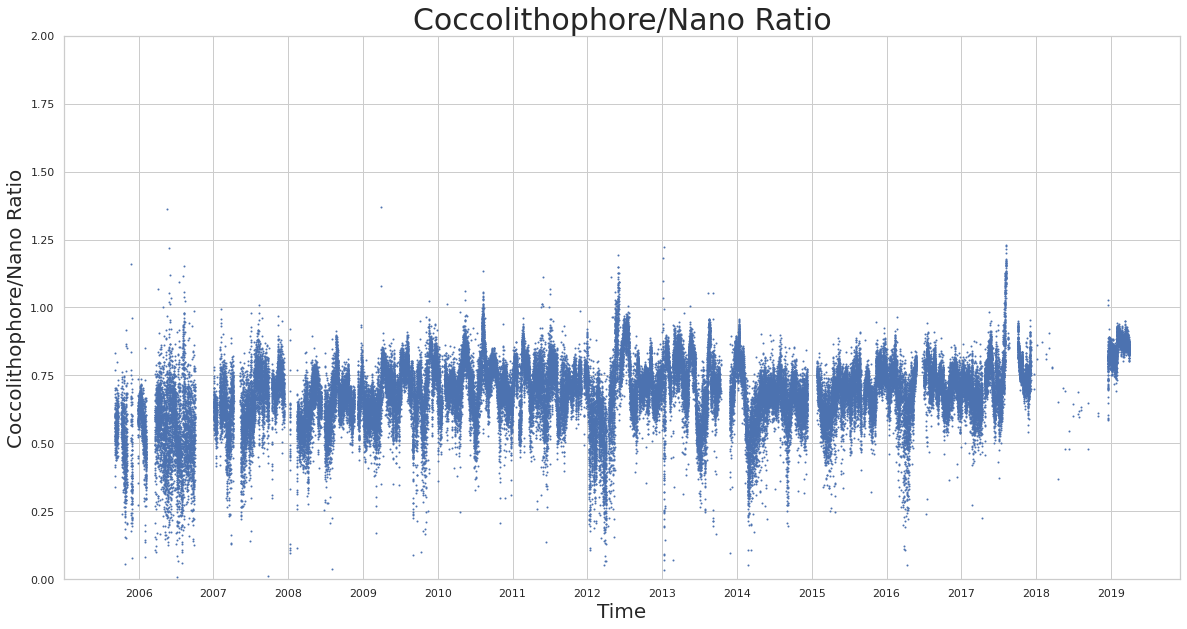

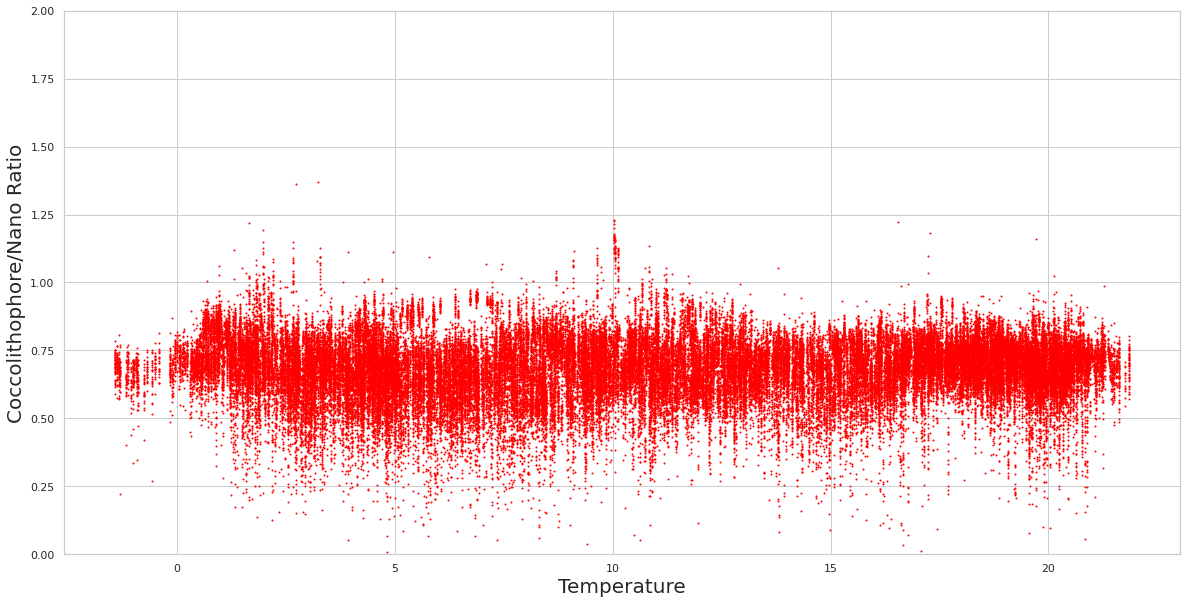

In [21]:
plotratios("Coccolithophore","Nano")

### incorporating ECOMON zoop data

In [51]:
import descartes
import geopandas as gpd
from shapely.geometry import Point, Polygon

In [23]:
ec_taxa = pd.read_excel("/D/MIT-WHOI/data/2021/EcoMon_Plankton_Data_v3_7_dnd.xlsx",
             sheet_name = 1)

ec_data = pd.read_excel("/D/MIT-WHOI/data/2021/EcoMon_Plankton_Data_v3_7_dnd.xlsx",
             sheet_name = 2)
ec_data["date"] = pd.to_datetime(ec_data["date"], format ="%Y-%m-%d" )

# print(ec_taxa.head())
print(ec_data.head())

  cruise_name  station zoo_gear ich_gear      lat      lon       date  \
0      AA8704       42      6B3      6B5  38.7500 -73.7500 1987-04-17   
1      AA8704       43      6B3      6B5  38.9500 -74.1167 1987-04-17   
2      AA8704       44      6B3      6B5  38.9167 -74.5500 1987-04-17   
3      AA8704       45      6B3      6B5  39.1000 -74.3167 1987-04-17   
4      AA8704       46      6B3      6B5  39.2333 -74.4333 1987-04-17   

       time  depth  sfc_temp  ...  botspp_100m3  hipobl_100m3  parden_100m3  \
0  00:45:00     54       NaN  ...           0.0           0.0           0.0   
1  02:50:00     46       NaN  ...           0.0           0.0           0.0   
2  04:35:00     28       NaN  ...           0.0           0.0           0.0   
3  06:05:00     24       NaN  ...           0.0           0.0           0.0   
4  07:00:00     18       NaN  ...           0.0           0.0           0.0   

   pseame_100m3  hippla_100m3  limfer_100m3  glycyn_100m3  scoaqu_100m3  \
0          

In [24]:

ec_data["year"] = pd.to_numeric(ec_data["date"].dt.year)


In [25]:
#looking at latitude and longitude
print(nes['lat'].min())
print(nes['lat'].max())
print(nes['lon'].min())
print(nes['lon'].max())

NameError: name 'nes' is not defined

In [52]:
nes = gpd.read_file("/D/MIT-WHOI/data/2021/lme/lme.shp")
fig,ax = plt.subplots(figsize = (5,5))
nes.plot(ax = ax)

<AxesSubplot:>

In [ ]:
geometry = [Point(xy) for xy in zip(ec_data["lon"],ec_data["lat"])]
crs = {'init':'epsg:4326'}
geo_df = gpd.GeoDataFrame(ec_data,crs =crs,geometry =geometry)

geo_df.head()

print(list(geo_df))

In [ ]:
#Contextily Providers
ctx.providers.keys()
ctx.providers.Esri.keys()
# ctx.providers.OpenSeaMap.keys()

In [ ]:
import contextily as ctx
fig,ax = plt.subplots(figsize = (15,15))
nes.plot(ax = ax, alpha = 0.4, color = "grey")
ax = geo_df.plot(ax=ax, markersize = 1, c = "red", marker = "o",label = "s")
ctx.add_basemap(ax,crs= geo_df.crs.to_string(),source = ctx.providers.Esri.WorldTerrain)
plt.xlabel("Longitude")
plt.ylabel("Latitude")

In [ ]:
import contextily as ctx
fig,ax = plt.subplots(figsize = (15,15))
nes.plot(ax = ax, alpha = 0.4, color = "grey")
ax = geo_df.plot(ax=ax, markersize = 1, c = geo_df["calfin_10m2"], marker = "o",label = "s",cmap = "RdPu",legend = True)
ctx.add_basemap(ax,crs= geo_df.crs.to_string(),source = ctx.providers.Esri.WorldTerrain)
plt.xlabel("Longitude")
plt.ylabel("Latitude")

In [ ]:
print(list(ec_data))

In [ ]:
def ecomon_ratios(x,y):
    
    fig,ax = plt.subplots(figsize = (15,15))
    nes.plot(ax = ax, alpha = 0.4, color = "grey")
    ax = geo_df.plot(ax=ax, markersize = 1, c = geo_df["date"], marker = "o",label = "s",cmap = "RdPu",legend = True)
    ctx.add_basemap(ax,crs= geo_df.crs.to_string(),source = ctx.providers.Esri.WorldTerrain)
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    
    figure(figsize=(10, 10), dpi=80) 
    #S1,S2, YEAR
    plt.scatter(np.log(ec_data[x]),
                np.log(ec_data[y]),
                c=ec_data["year"],
               cmap = "Blues",
               s = 3)

    plt.colorbar()
    plt.xlabel("log("+x+")",size = 17)
    plt.ylabel("log("+y+")",size = 17)
    plt.title(x+"/"+y+ " Ratio by Year",size = 20)
    
    #TIME VS RATIO
    ec_data["Ratio"]=np.log(ec_data[x])/np.log(ec_data[y])

    fig, ax = plt.subplots(figsize=(20,10))

    ax.scatter(ec_data["date"],
              ec_data["Ratio"]
               ,s= 1)

    fmt_full_year = mdates.MonthLocator(interval=24)
    ax.xaxis.set_major_locator(fmt_full_year)
    # ax.plot(ec_data["datetime"],ec_data["SMA_100"],color = "red")

    plt.xlabel("Year",size = 20)
    plt.ylabel(x+"/"+y+" Ratio",size = 20)
    plt.ylim((0,3))
    plt.title(x+"/"+y+" Ratio",size = 30)

    date_form = DateFormatter("%y")
    ax.xaxis.set_major_formatter(date_form)

ecomon_ratios("calfin_10m2","pseudo_10m2")

In [5]:
# fig = plt.figure(figsize=(12,10))
# ax = plt.axes(projection='3d')
# ax.scatter3D(np.log(df_short["Diatom"]),
#              np.log(df_short["Dinoflagellate"]),
#              np.log(df_short["Nano"]),
#             c = df_short["year"],
#             cmap = "Greens")
# ax.set_xlabel("logDiatoms")
# ax.set_ylabel("logDino")
# ax.set_zlabel("logNano")

# # rotate the axes and update
# for angle in range(0, 360):
#     ax.view_init(30, angle)
#     plt.draw()
#     plt.pause(.001)

In [45]:
%matplotlib qt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np

fig = plt.figure()
ax = fig.gca(projection='3d')

scale = 8


ax.scatter3D(np.log(df_short["Diatom"]),
             np.log(df_short["Dinoflagellate"]),
             np.log(df_short["Nano"]),
            c = df_short["year"],
            cmap = "Greens")
ax.set_xlabel("logDiatoms")
ax.set_ylabel("logDino")
ax.set_zlabel("logNano")

# Customize the z axis.
# ax.set_zlim(0, 100)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# rotate the axes and update
for angle in range(0, 360):
   ax.view_init(30, 40)

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

TypeError: Input z must be 2D, not 1D

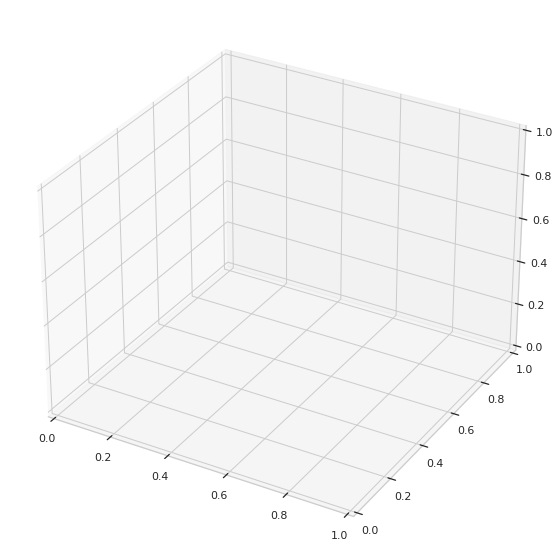

In [37]:
fig = plt.figure(figsize=(12,10))
ax = plt.axes(projection='3d')
ax.contour3D(np.log(df_short["Diatom"]),
             np.log(df_short["Dinoflagellate"]),
             np.log(df_short["Nano"]),
            cmap = 'binary')
ax.set_xlabel("logDiatoms")
ax.set_ylabel("logDino")
ax.set_zlabel("logNano")

[[ 8.07261091e-01  9.41437765e-01  9.97705708e-01  9.80850719e-01
   9.02160390e-01  7.77003505e-01  6.22348946e-01  4.54593535e-01
   2.87954298e-01  1.33543814e-01 -8.84706779e-04 -1.10640850e-01
  -1.93431827e-01 -2.48533645e-01 -2.75989644e-01 -2.75989644e-01
  -2.48533645e-01 -1.93431827e-01 -1.10640850e-01 -8.84706779e-04
   1.33543814e-01  2.87954298e-01  4.54593535e-01  6.22348946e-01
   7.77003505e-01  9.02160390e-01  9.80850719e-01  9.97705708e-01
   9.41437765e-01  8.07261091e-01]
 [ 9.41437765e-01  9.98937218e-01  9.71132423e-01  8.69941049e-01
   7.12998635e-01  5.20584150e-01  3.12742785e-01  1.07000578e-01
  -8.30932252e-02 -2.48533645e-01 -3.84629319e-01 -4.90176225e-01
  -5.66292335e-01 -6.15169883e-01 -6.38962142e-01 -6.38962142e-01
  -6.15169883e-01 -5.66292335e-01 -4.90176225e-01 -3.84629319e-01
  -2.48533645e-01 -8.30932252e-02  1.07000578e-01  3.12742785e-01
   5.20584150e-01  7.12998635e-01  8.69941049e-01  9.71132423e-01
   9.98937218e-01  9.41437765e-01]
 [ 9.9

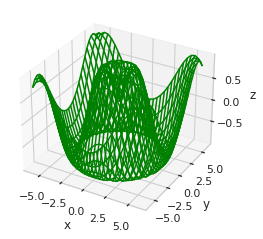

In [41]:

def z_function(x, y):
    return np.sin(np.sqrt(x ** 2 + y ** 2))

x = np.linspace(-6, 6, 30)
y = np.linspace(-6, 6, 30)

X, Y = np.meshgrid(x, y)
Z = z_function(X, Y)
print(Z)
fig = plt.figure()
ax = plt.axes(projection="3d")
ax.plot_wireframe(X, Y, Z, color='green')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

plt.show()